# Part 1. Install Packages

In [31]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
## install additional packages for dynamic weighting
!pip install torch scikit-learn seaborn

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to c:\users\ronit khanna\appdata\local\temp\pip-req-build-ejbzu57x
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit efc711f35e19b9ca5c5d0da2f8812f4719d613a8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to c:\users\ronit khanna\appdata\local\temp\pip-install-ynw15yms\elegantrl_f987e3c7b5c14b4fb0969deee5b8406d
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b2ec84b19a82e6f18b781743d8bf37ca27134238
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel

  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git 'C:\Users\Ronit Khanna\AppData\Local\Temp\pip-req-build-ejbzu57x'
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git 'C:\Users\Ronit Khanna\AppData\Local\Temp\pip-install-ynw15yms\elegantrl_f987e3c7b5c14b4fb0969deee5b8406d'


In [32]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Build A Market Environment in OpenAI Gym-style

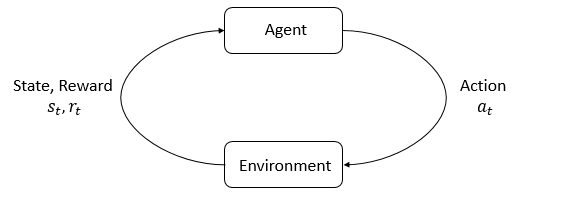

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process: 

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [33]:
train = pd.read_csv('train_data.csv')
# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [34]:
stock_dimension = len(train.tic.unique())# Get the number of unique stocks in the training data
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension#number of actions the agent can take
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 46, State Space: 461


In [35]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
print("vix" in train.columns)  # → False
  # → False

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

False


## Environment for training

In [36]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
  # → False


<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [37]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [38]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [39]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 109       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -65.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -78.9     |
|    reward             | 1.2376329 |
|    reward_max         | 7.6640234 |
|    reward_mean        | 3.4590993 |
|    reward_min         | 1.2376329 |
|    std                | 1         |
|    value_loss         | 2.11      |
-------------------------------------


In [40]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [41]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [42]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=500) if if_using_ddpg else None

Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [43]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [44]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [45]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200) if if_using_ppo else None

-------------------------------------
| time/              |              |
|    fps             | 180          |
|    iterations      | 1            |
|    time_elapsed    | 11           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.18428643  |
|    reward_max      | 6.5897713    |
|    reward_mean     | -0.011924044 |
|    reward_min      | -4.754974    |
-------------------------------------


In [46]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [47]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [48]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=500) if if_using_td3 else None

Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [49]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [50]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [51]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=700) if if_using_sac else None

Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [52]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.

For Colab users, the zip files should be at "./trained_models" or "/content/trained_models".

For users running on your local environment, the zip files should be at "./trained_models".

# Part 4: Dynamic Weighting System Implementation

After training individual RL agents, we'll implement a dynamic weighting system that uses machine learning models (LSTM/Transformer) to predict which strategies will perform best in the near future and adjust portfolio weights accordingly.

In [53]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Tuple, Optional
import logging
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Dynamic weighting libraries loaded!")

✅ Dynamic weighting libraries loaded!


## Dynamic Weighting Classes and Functions

In [54]:
class StrategyReturnsDataset(Dataset):
    """Dataset for strategy returns time series"""

    def __init__(self, data: pd.DataFrame, lookback_window: int = 10,
                 target_col: str = 'returns', feature_cols: List[str] = None):
        """
        Args:
            data: DataFrame with strategy returns and features
            lookback_window: Number of past days to use for prediction
            target_col: Column name for target returns
            feature_cols: List of feature column names
        """
        self.data = data
        self.lookback_window = lookback_window
        self.target_col = target_col
        self.feature_cols = feature_cols or [target_col]

        # Prepare sequences
        self.sequences = []
        self.targets = []

        for i in range(lookback_window, len(data)):
            # Features: past lookback_window days
            seq = data[self.feature_cols].iloc[i-lookback_window:i].values
            self.sequences.append(seq)

            # Target: next day's return
            target = data[target_col].iloc[i]
            self.targets.append(target)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.sequences[idx]),
                torch.FloatTensor([self.targets[idx]]))


In [55]:
class LSTMPredictor(nn.Module):
    """LSTM model for predicting strategy returns"""

    def __init__(self, input_size: int, hidden_size: int = 64,
                 num_layers: int = 2, dropout: float = 0.2):
        super(LSTMPredictor, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)

        # Take the last output
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)

        return out


In [56]:
class TransformerPredictor(nn.Module):
    """Transformer model for predicting strategy returns"""

    def __init__(self, input_size: int, d_model: int = 64, nhead: int = 8,
                 num_layers: int = 3, dropout: float = 0.2):
        super(TransformerPredictor, self).__init__()

        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1000, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        seq_len = x.size(1)

        # Project input to d_model dimensions
        x = self.input_projection(x)

        # Add positional encoding
        x = x + self.positional_encoding[:seq_len, :].unsqueeze(0)

        # Apply transformer
        x = self.transformer(x)

        # Take the last output
        last_out = x[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)

        return out


In [57]:
class DynamicWeightingSystem:
    """
    Dynamic weighting system that uses ML models to predict strategy returns
    and dynamically adjusts portfolio weights
    """

    def __init__(self, strategy_names: List[str], model_type: str = 'lstm',
                 lookback_window: int = 10, rebalance_freq: int = 1):
        """
        Args:
            strategy_names: List of RL strategy names (e.g., ['A2C', 'PPO', 'SAC'])
            model_type: 'lstm' or 'transformer'
            lookback_window: Number of past days for prediction
            rebalance_freq: How often to rebalance (1 = daily)
        """
        self.strategy_names = strategy_names
        self.model_type = model_type
        self.lookback_window = lookback_window
        self.rebalance_freq = rebalance_freq

        # Initialize models for each strategy
        self.models = {}
        self.scalers = {}

        # Training parameters
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

    def create_features(self, returns_df: pd.DataFrame) -> pd.DataFrame:
        """Create additional features from returns"""
        features_df = returns_df.copy()

        for strategy in self.strategy_names:
            if strategy in features_df.columns:
                # Technical indicators
                features_df[f'{strategy}_volatility'] = features_df[strategy].rolling(5).std()
                features_df[f'{strategy}_momentum'] = features_df[strategy].rolling(3).mean()
                features_df[f'{strategy}_rsi'] = self._calculate_rsi(features_df[strategy])

                # Lag features
                features_df[f'{strategy}_lag1'] = features_df[strategy].shift(1)
                features_df[f'{strategy}_lag2'] = features_df[strategy].shift(2)

        return features_df.fillna(0)

    def _calculate_rsi(self, series: pd.Series, period: int = 14) -> pd.Series:
        """Calculate RSI indicator"""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def prepare_training_data(self, returns_df: pd.DataFrame) -> Dict:
        """Prepare training data for all strategies"""
        features_df = self.create_features(returns_df)
        datasets = {}

        for strategy in self.strategy_names:
            if strategy in features_df.columns:
                # Get feature columns for this strategy
                feature_cols = [col for col in features_df.columns
                              if col.startswith(strategy)]

                # Create dataset
                dataset = StrategyReturnsDataset(
                    features_df,
                    lookback_window=self.lookback_window,
                    target_col=strategy,
                    feature_cols=feature_cols
                )
                datasets[strategy] = dataset

                # Create scaler for this strategy
                scaler = StandardScaler()
                scaler.fit(features_df[feature_cols].values)
                self.scalers[strategy] = scaler

        return datasets

    def train_models(self, returns_df: pd.DataFrame, epochs: int = 100,
                    batch_size: int = 32, learning_rate: float = 0.001):
        """Train prediction models for all strategies"""
        datasets = self.prepare_training_data(returns_df)

        for strategy, dataset in datasets.items():
            logger.info(f"Training model for {strategy}...")

            # Create data loader
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            # Get input size
            sample_batch = next(iter(dataloader))
            input_size = sample_batch[0].shape[2]

            # Create model
            if self.model_type == 'lstm':
                model = LSTMPredictor(input_size=input_size)
            else:
                model = TransformerPredictor(input_size=input_size)

            model.to(self.device)

            # Training setup
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

            # Training loop
            model.train()
            for epoch in range(epochs):
                total_loss = 0
                for batch_x, batch_y in dataloader:
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)

                    optimizer.zero_grad()
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                scheduler.step()

                if (epoch + 1) % 20 == 0:
                    avg_loss = total_loss / len(dataloader)
                    logger.info(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

            self.models[strategy] = model
            logger.info(f"Model training completed for {strategy}")

    def predict_returns(self, recent_data: pd.DataFrame) -> Dict[str, float]:
        """Predict next period returns for all strategies"""
        predictions = {}
        features_df = self.create_features(recent_data)

        for strategy in self.strategy_names:
            if strategy in self.models:
                model = self.models[strategy]
                scaler = self.scalers[strategy]

                # Get recent features
                feature_cols = [col for col in features_df.columns
                              if col.startswith(strategy)]

                # Prepare input data
                recent_features = features_df[feature_cols].tail(self.lookback_window)
                scaled_features = scaler.transform(recent_features.values)

                # Make prediction
                model.eval()
                with torch.no_grad():
                    input_tensor = torch.FloatTensor(scaled_features).unsqueeze(0).to(self.device)
                    prediction = model(input_tensor).cpu().numpy()[0][0]
                    predictions[strategy] = prediction

        return predictions

    def calculate_dynamic_weights(self, predictions: Dict[str, float],
                                risk_aversion: float = 0.5) -> Dict[str, float]:
        """Calculate dynamic weights based on predictions"""
        if not predictions:
            # Equal weights if no predictions
            equal_weight = 1.0 / len(self.strategy_names)
            return {strategy: equal_weight for strategy in self.strategy_names}

        # Convert predictions to positive scores
        pred_values = np.array(list(predictions.values()))

        # Apply risk adjustment
        if risk_aversion > 0:
            # Penalize negative predictions more
            scores = np.where(pred_values > 0, pred_values, pred_values * (1 + risk_aversion))
        else:
            scores = pred_values

        # Convert to positive weights using softmax
        exp_scores = np.exp(scores - np.max(scores))  # Numerical stability
        weights = exp_scores / np.sum(exp_scores)

        # Ensure minimum weight for diversification
        min_weight = 0.05
        weights = np.maximum(weights, min_weight)
        weights = weights / np.sum(weights)  # Renormalize

        return dict(zip(predictions.keys(), weights))

print("✅ Dynamic weighting system classes loaded successfully!")

✅ Dynamic weighting system classes loaded successfully!


# Part 5: Save Enhanced Training Data and Models

Save the trained models and prepare for dynamic weighting analysis. The trained models will be used in the backtesting notebook to generate strategy returns, which will then be used to train the dynamic weighting system.

In [58]:
# Save model information for dynamic weighting
model_info = {
    'strategy_names': [],
    'model_paths': {},
    'training_completed': True
}

# Collect information about trained models
if if_using_a2c and trained_a2c:
    model_info['strategy_names'].append('A2C')
    model_info['model_paths']['A2C'] = TRAINED_MODEL_DIR + "/agent_a2c"

if if_using_ddpg and trained_ddpg:
    model_info['strategy_names'].append('DDPG')
    model_info['model_paths']['DDPG'] = TRAINED_MODEL_DIR + "/agent_ddpg"

if if_using_ppo and trained_ppo:
    model_info['strategy_names'].append('PPO')
    model_info['model_paths']['PPO'] = TRAINED_MODEL_DIR + "/agent_ppo"

if if_using_td3 and trained_td3:
    model_info['strategy_names'].append('TD3')
    model_info['model_paths']['TD3'] = TRAINED_MODEL_DIR + "/agent_td3"

if if_using_sac and trained_sac:
    model_info['strategy_names'].append('SAC')
    model_info['model_paths']['SAC'] = TRAINED_MODEL_DIR + "/agent_sac"

# Save model information
import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Model information saved for dynamic weighting system!")
print(f"📊 Trained strategies: {model_info['strategy_names']}")
print("🎯 Ready for dynamic weighting backtesting!")

✅ Model information saved for dynamic weighting system!
📊 Trained strategies: ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC']
🎯 Ready for dynamic weighting backtesting!


# Part 6: Initialize Dynamic Weighting System

Initialize the dynamic weighting system that will be used in the backtesting phase. This system will learn to predict which strategies will perform best and adjust weights accordingly.

In [59]:
# Initialize dynamic weighting systems (both LSTM and Transformer)
if len(model_info['strategy_names']) >= 2:  # Need at least 2 strategies for ensemble
    print("🤖 Initializing Dynamic Weighting Systems...")

    # LSTM-based system
    dws_lstm = DynamicWeightingSystem(
        strategy_names=model_info['strategy_names'],
        model_type='lstm',
        lookback_window=15,
        rebalance_freq=1
    )

    # Transformer-based system
    dws_transformer = DynamicWeightingSystem(
        strategy_names=model_info['strategy_names'],
        model_type='transformer',
        lookback_window=15,
        rebalance_freq=1
    )

    print("✅ Dynamic weighting systems initialized!")
    print(f"📈 LSTM system ready for {len(model_info['strategy_names'])} strategies")
    print(f"🔄 Transformer system ready for {len(model_info['strategy_names'])} strategies")
    print("🎯 Systems will be trained during backtesting phase")

else:
    print("⚠️ Need at least 2 trained strategies for dynamic weighting")
    print("Please ensure multiple strategies are trained before proceeding")

INFO:__main__:Using device: cpu
INFO:__main__:Using device: cpu


🤖 Initializing Dynamic Weighting Systems...
✅ Dynamic weighting systems initialized!
📈 LSTM system ready for 5 strategies
🔄 Transformer system ready for 5 strategies
🎯 Systems will be trained during backtesting phase


# Part 7: Training Summary and Next Steps

In [60]:
print("\n" + "="*60)
print("🎉 TRAINING PHASE COMPLETE!")
print("="*60)

print(f"\n📊 Training Summary:")
print(f"   • Total strategies trained: {len(model_info['strategy_names'])}")
print(f"   • Strategy names: {', '.join(model_info['strategy_names'])}")
print(f"   • Models saved to: {TRAINED_MODEL_DIR}")
print(f"   • Dynamic weighting ready: {'✅' if len(model_info['strategy_names']) >= 2 else '❌'}")

print(f"\n🎯 Next Steps:")
print(f"   1. Run the backtesting notebook (Part 3)")
print(f"   2. Generate strategy returns from trained models")
print(f"   3. Train dynamic weighting models on strategy returns")
print(f"   4. Compare ensemble performance vs individual strategies")
print(f"   5. Analyze weight evolution and performance metrics")

print(f"\n💡 Dynamic Weighting Features:")
print(f"   • LSTM & Transformer models for return prediction")
print(f"   • Automatic feature engineering from strategy returns")
print(f"   • Risk-adjusted weight calculation")
print(f"   • Real-time portfolio rebalancing")
print(f"   • Comprehensive performance analysis")

print("\n" + "="*60)
print("Ready for Part 3: Backtesting with Dynamic Weighting!")
print("="*60)



🎉 TRAINING PHASE COMPLETE!

📊 Training Summary:
   • Total strategies trained: 5
   • Strategy names: A2C, DDPG, PPO, TD3, SAC
   • Models saved to: trained_models
   • Dynamic weighting ready: ✅

🎯 Next Steps:
   1. Run the backtesting notebook (Part 3)
   2. Generate strategy returns from trained models
   3. Train dynamic weighting models on strategy returns
   4. Compare ensemble performance vs individual strategies
   5. Analyze weight evolution and performance metrics

💡 Dynamic Weighting Features:
   • LSTM & Transformer models for return prediction
   • Automatic feature engineering from strategy returns
   • Risk-adjusted weight calculation
   • Real-time portfolio rebalancing
   • Comprehensive performance analysis

Ready for Part 3: Backtesting with Dynamic Weighting!
